# Five cars


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/five_cars/"
sz = 224
arch = resnext101_64
bs = 58

In [4]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [5]:
n

1006

In [6]:
len(val_idxs)

201

## Initial exploration

In [7]:
!ls {PATH}

cars       labels.csv tmp        train


In [8]:
label_df = pd.read_csv(label_csv)

In [9]:
label_df.head()

,file_name,class
0,BMW_X5_id_1_026c4ab1c4122f523fa3919e9fdccdb4,BMW_X5
1,BMW_X5_id_2_04bmwx5mreview2010,BMW_X5
2,BMW_X5_id_3_1 (1),BMW_X5
3,BMW_X5_id_4_1,BMW_X5
4,BMW_X5_id_5_11-BMW-X5-E53-4.4i-Facelift-1200x835,BMW_X5


In [11]:
label_df.pivot_table(index="class", aggfunc=len).sort_values('file_name', ascending=False)

,file_name
class,
Mazda_CX5,214
BMW_X5,201
Chevrolet_Captiva,198
TAYOTA_Camry,197
Chevrolet_Lacetti,196


In [12]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv',
                                   val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

In [13]:
fn = PATH + data.trn_ds.fnames[2]; fn

'data/five_cars/train/BMW_X5_id_3_1 (1).jpg'

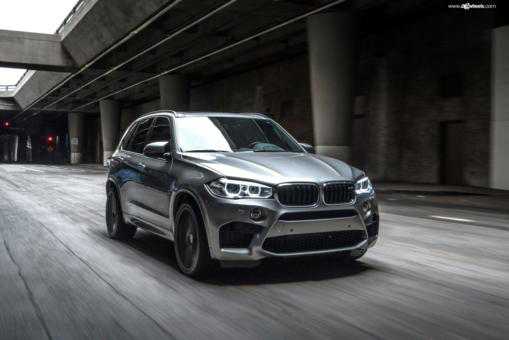

In [14]:
img = PIL.Image.open(fn); img

In [15]:
img.size

(509, 340)

In [16]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [17]:
row_sz, col_sz = list(zip(*size_d.values()))

In [18]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [19]:
row_sz[:5]

array([604, 512, 509, 453, 488])

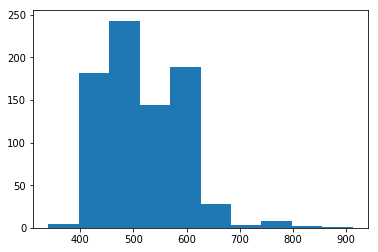

In [20]:
plt.hist(row_sz);

(array([  5., 182., 243., 144., 189.,  28.,   3.,   8.,   2.,   1.]),
 array([340. , 397.3, 454.6, 511.9, 569.2, 626.5, 683.8, 741.1, 798.4, 855.7, 913. ]),
 <a list of 10 Patch objects>)

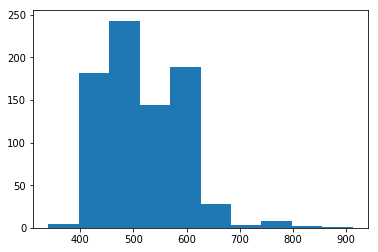

In [21]:
plt.hist(row_sz[row_sz < 1000])

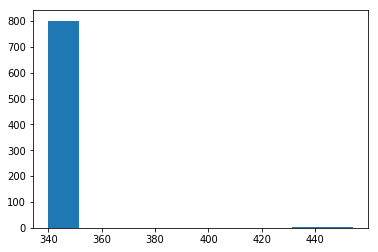

In [22]:
plt.hist(col_sz);

(array([801.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   2.]),
 array([340. , 351.4, 362.8, 374.2, 385.6, 397. , 408.4, 419.8, 431.2, 442.6, 454. ]),
 <a list of 10 Patch objects>)

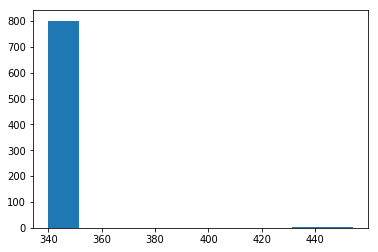

In [23]:
plt.hist(col_sz[col_sz < 1000])

In [24]:
len(data.trn_ds)

805

In [25]:
len(data.classes), data.classes[:5]

(5,
 ['BMW_X5',
  'Chevrolet_Captiva',
  'Chevrolet_Lacetti',
  'Mazda_CX5',
  'TAYOTA_Camry'])

## Initial model

In [26]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv',
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time

#Source:   
#    def resize(self, targ, new_path):
#        new_ds = []
#        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
#        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
#        else: dls += [None,None]
#        t = tqdm_notebook(dls)
#        for dl in t: new_ds.append(self.resized(dl, targ, new_path))
#        t.close()
#        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)
#File:      ~/fastai/courses/dl1/fastai/dataset.py

### Precompute

In [27]:
data = get_data(sz, bs)

In [28]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 4/4 [03:14<00:00, 47.10s/it]


In [29]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                 
    0      1.23834    0.674969   0.741294  
    1      0.769398   0.459054   0.820896                  
    2      0.538553   0.406814   0.845771                  
    3      0.402108   0.386182   0.860697                  
    4      0.311852   0.368605   0.850746                  



[array([0.36861]), 0.8507462686567164]

### Test results

In [30]:
learn.save('5cars_pre')

In [31]:
learn.load('5cars_pre')

In [32]:
len(data.val_ds.fnames)

201

In [33]:
fn = data.val_ds.fnames[155]
fn

'train/Mazda_CX5_id_179_mazda_2017_cx_5_eu_version_010.jpg'

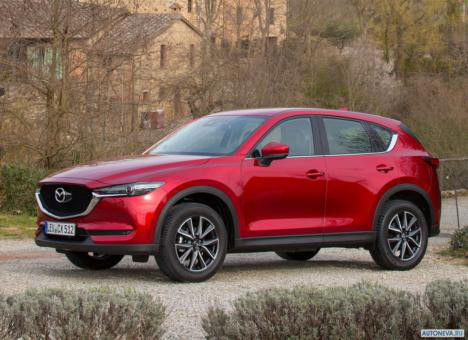

In [34]:
Image.open(PATH + fn)

In [35]:
# predict
trn_tfms, val_tfms = tfms_from_model(arch, sz)
im = val_tfms(open_image(PATH + fn)) # open_image() returns numpy.ndarray
preds = learn.predict_array(im[None])
id = np.argmax(preds)
data.classes[id]

'Mazda_CX5'

### Augment

In [38]:
from sklearn import metrics

In [39]:
data = get_data(sz, bs)

In [40]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [41]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                 
    0      1.397263   0.729425   0.771144  
    1      0.911122   0.464614   0.825871                  



[array([0.46461]), 0.8258706467661692]

In [42]:
learn.precompute = False

In [43]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.598374   0.437012   0.835821  
    1      0.551208   0.411239   0.850746                  
    2      0.515959   0.392621   0.860697                  
    3      0.479273   0.377339   0.875622                  
    4      0.458634   0.362344   0.875622                  



[array([0.36234]), 0.8756218905472637]

In [23]:
learn.save('5cars_pre')

In [ ]:
learn.load('5cars_pre')

## Increase size

In [44]:
# Starting training on small images for a few epochs, then switching to bigger images, and continuing training is an amazingly effective way to avoid overfitting.

# http://forums.fast.ai/t/planet-classification-challenge/7824/96
# set_data doesn’t change the model at all. It just gives it new data to train with.
learn.set_data(get_data(299, bs)) 
learn.freeze()

#Source:   
#    def set_data(self, data, precompute=False):
#        super().set_data(data)
#        if precompute:
#            self.unfreeze()
#            self.save_fc1()
#            self.freeze()
#            self.precompute = True
#        else:
#            self.freeze()
#File:      ~/fastai/courses/dl1/fastai/conv_learner.py

In [45]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 299, 299]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 75, 

In [46]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.439364   0.381296   0.870647  
    1      0.398239   0.360191   0.880597                   
    2      0.368793   0.360275   0.900498                  



[array([0.36028]), 0.900497512437811]

In [ ]:
# When you are under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly).
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2) # 1+2+4 = 7 epochs

In [ ]:
log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)
probs = np.mean(np.exp(log_preds),0)

In [50]:
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9154228855721394, 0.32269788023914947)

In [51]:
len(data.val_ds.y), data.val_ds.y[:5]

(201, array([0, 0, 0, 0, 0]))

In [52]:
learn.save('5cars299_pre')

In [53]:
learn.load('5cars299_pre')

## Individual prediction

In [63]:
fn = data.val_ds.fnames[175]
fn

'train/TAYOTA_Camry_id_69_32241190002_original.jpg'

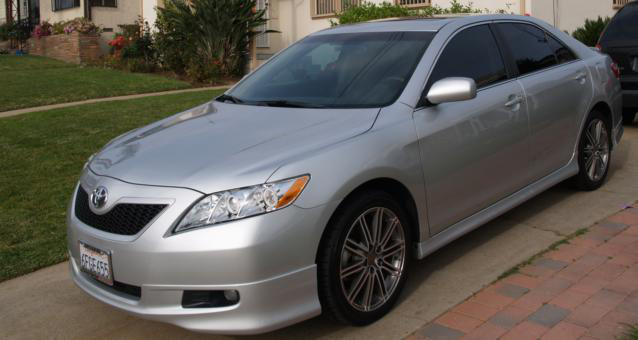

In [64]:
Image.open(PATH + fn)

In [65]:
# Method 1.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

4

In [66]:
learn.data.classes[np.argmax(preds)]

'TAYOTA_Camry'

In [67]:
# Method 2.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
im = val_tfms(open_image(PATH + fn)) # open_image() returns numpy.ndarray
preds = learn.predict_array(im[None])
np.argmax(preds)

4

In [68]:
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9154228855721394, 0.32269788023914947)